# DFT calculated energies

#### Imports

In [177]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import numpy as np
from ase.db import connect
import sys
import pandas as pd
from sklearn.model_selection import train_test_split;
import xgboost as xgb
from xgboost import XGBRegressor;
import time
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import Counter

figure_folder = "../figures/DFT_calc_energies/"
DFT_folder = "../DFT_data/"
db_folder = "../DFT_data/"
# The COOH Pt data is in "single_element_COOH_C_adsorbed_out.db"
db_name_SE_COOH = "single_element_COOH_C_adsorbed_out.db"
# THe H data is in "single_element_H_out.db"
db_name_SE_H = "single_element_H_out.db"
db_name_SE = "single_element_slabs_out.db"

sys.path.append('../scripts')
from Slab import expand_triangle, Slab, inside_triangle
from FeatureReader import OntopStandard111, FccStandard111
from ase.db import connect
from ase.visualize import view

features_folder = "../csv_features/"

import sys
import os

# Define the path to the folder containing the functions.py file
path_to_functions = "../scripts/functions.py"

# Get the absolute path of the functions.py file
absolute_path = os.path.abspath(path_to_functions)

# Add the folder containing the functions.py file to the module search path
sys.path.append(os.path.dirname(absolute_path))

# Now you can import the learning_curve function from functions.py
from functions import learning_curve, single_parity_plot

#Load H binding energy prediction model
H_DFT_model = xgb.Booster({'nthread': 8})
H_DFT_model.load_model("../models/"+"H_DFT.model")

#Load COOH binding energy prediction model
COOH_DFT_model = xgb.Booster({'nthread': 8})
COOH_DFT_model.load_model("../models/"+"COOH_DFT.model")

models = {"H": H_DFT_model, "COOH": COOH_DFT_model}

#### Chan numbers

In [2]:
# Free (eV)
CO2   = {"ZPE": 0.31, "CpdT": 0.10, "minusTS": -0.66, "TS": 0.66}
CO    = {"ZPE": 0.13, "CpdT": 0.09, "minusTS": -0.61, "TS": 0.61}
H2    = {"ZPE": 0.28, "CpdT": 0.09, "minusTS": -0.40, "TS": 0.40}
H2O   = {"ZPE": 0.57, "CpdT": 0.10, "minusTS": -0.67, "TS": 0.67}
HCOOH = {"ZPE": 0.90, "CpdT": 0.11, "minusTS": -0.99, "TS": 0.99}
#Slab = {"ZPE": 0.00, "CpdT": 0.00, "minusTS": -0.00} #Holy moly, den her overskrev Slab funktionen

# *Bound to the surface (eV)
# Bidentate *OOCH?
bound_CO   = {"ZPE": 0.19, "CpdT": 0.08, "minusTS": -0.16, "TS": 0.16}
bound_OH   = {"ZPE": 0.36, "CpdT": 0.05, "minusTS": -0.08, "TS": 0.08}
bound_OCHO = {"ZPE": 0.62, "CpdT": 0.11, "minusTS": -0.24, "TS": 0.24} #Either bidentate or monodentate. Use for both for now
bound_O    = {"ZPE": 0.07, "CpdT": 0.03, "minusTS": -0.04, "TS": 0.04}
bound_COOH = {"ZPE": 0.62, "CpdT": 0.10, "minusTS": -0.19, "TS": 0.19}
bound_H    = {"ZPE": 0.23, "CpdT": 0.01, "minusTS": -0.01, "TS": 0.01}

# Approximation Factors (FA)
AF = {"CO2": CO2, "CO": CO, "H2": H2, "H2O": H2O, "HCOOH": HCOOH, \
      "bound_CO": bound_CO, "bound_OH": bound_OH, "bound_OCHO": bound_OCHO, \
      "bound_O": bound_O, "bound_COOH": bound_COOH, "bound_H": bound_H}

# This is from the molecules_out.db file
molecules_dict = {'CO': -12.848598765234707,\
 'CO2': -19.15168636258064,\
 'CH2O2': -25.7548327798152,\
 'C2H4O2': -41.95993780269195,\
 'H2': -6.67878491734772,\
 'H2O': -12.225511685485456,\
 'CH2O': -19.92286258910958,\
 'CH4O': -27.652189372849637,\
 'C2H6O': -43.67355392866396,\
 'C2H2O2': -32.92328015484662,\
 'C2H2O4': -44.117581976029946}

#### Plotting

#### Fetching DFT data

In [3]:
SE_COOH_metals = []
SE_COOH_energies = []

with connect(f'{DFT_folder}{db_name_SE_COOH}') as db_COOH:
    for row_slab in db_COOH.select('energy'):
        SE_COOH_energies.append(row_slab.energy)
        SE_COOH_metals.append(row_slab.formula[0:2])

SE_H_metals = []
SE_H_energies = []

with connect(f'{DFT_folder}{db_name_SE_H}') as db_H:
    for row_slab in db_H.select('energy'):
        SE_H_energies.append(row_slab.energy)
        SE_H_metals.append(row_slab.formula[0:2])
           
SE_slab_metals = []
SE_slab_energies = []

with connect(f'{DFT_folder}{db_name_SE}') as db_slab:
    for row_slab in db_slab.select('energy'):
        SE_slab_energies.append(row_slab.energy)
        SE_slab_metals.append(row_slab.formula[0:2])

#### Subtracting the slabs

In [4]:
DeltaE_COOH = np.array(SE_COOH_energies) - np.array(SE_slab_energies) - molecules_dict["CO2"] - 1/2*molecules_dict["H2"]
DeltaE_H = np.array(SE_H_energies) - np.array(SE_slab_energies) - 1/2*molecules_dict["H2"]

#### Plotting energies from single elements

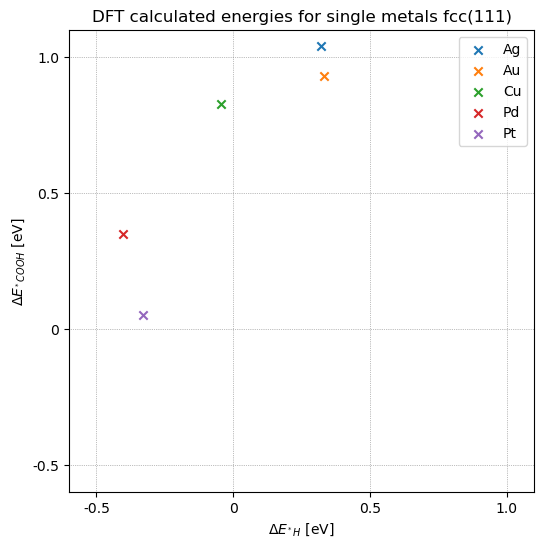

In [5]:
# Create a figure and axes
fig, ax = plt.subplots(figsize = (6, 6))

# Set the limits for both x and y axes
ax.set_xlim(-0.6, 1.1)
ax.set_ylim(-0.6, 1.1)

## Set the major ticks and tick labels
#ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
#ax.set_xticklabels([-0.5, '', 0, '', 0.5, '', 1.0])
#ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
#ax.set_yticklabels([-0.5, '', 0, '', 0.5, '', 1.0])

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xticklabels([-0.5, 0, 0.5, 1.0])
ax.set_yticks([-0.5, 0, 0.5, 1.0])
ax.set_yticklabels([-0.5, 0, 0.5, 1.0])

# Set the grid lines
ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray')

ax.set_title("DFT calculated energies for single metals fcc(111)")
ax.set_xlabel("$\Delta E_{^*H}$ [eV]")
ax.set_ylabel("$\Delta E_{^*COOH}$ [eV]")

for i, metal in enumerate(SE_slab_metals):
    ax.scatter(DeltaE_H[i], DeltaE_COOH[i], label = metal, marker = "x")
    #print(SE_H[i])
    #print(SE_COOH[i])
    
ax.legend()

# Show the plot
plt.show()

### Plotting predicted energies from custom surface

In [125]:
# Maybe I should have a smart kind of plot, where, when you hover over it, it shows the xy coordinates and you can go check what it looks like. I even have a function from the swimming ring thing that can plot nice circles from a 2by2 surface

## This routine includes: 

# Initialize a surface from a given stochiometry
dim_x, dim_y, metals, split = 100, 100, ['Ag', 'Au', 'Cu', 'Pd', 'Pt'], [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]
#dim_x, dim_y, metals, split = 100, 100, ['Ag', 'Au', 'Cu', 'Pd', 'Pt'], [0.25 , 0.25 , 0.25 , 0.0 , 0.25 ]
#dim_x, dim_y, metals, split = 100, 100, ['Ag', 'Au', 'Cu', 'Pd', 'Pt'], [0.0 , 6/7 , 0.0 , 0.0 , 1/7 ]
#dim_x, dim_y, metals, split = 100, 100, ['Ag', 'Au', 'Cu', 'Pd', 'Pt'], [0.1 , 0.9/4 , 0.9/4 , 0.9/4 , 0.9/4 ]
#dim_x, dim_y, metals, split = 100, 100, ['Ag', 'Au', 'Cu', 'Pd', 'Pt'], [0.1 , 0.1 , 0.1 , 0.1 , 0.6 ]
stochiometry = dict(zip(metals, split))
surface = initialize_surface(dim_x, dim_y, metals, split)

# Predict energies on all sites for both adsorbates
surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)

# But uhh H and COOH aren't on the same sites

# Wait, COOH and H don't sit on the same sites.

Predicting all ΔG:   0%|          | 0/10000 [00:00<?, ?it/s]

#### Sort the energies into piles that come from the same top-site metal

The \*COOH adsorbates sit on top-sites, where a single atom is the primary influence on the binding energy. They are surrounded by \*H adsorbates in hollow-sites, where three atoms are the primary influence on the binding energy.

In the following plot, two energies have to be paired. All pairs between on-top site and hollow site will be plotted. This will result in 3 points per on-top site, one with each neighbour.

Uhh jeg kunne sortere alle hollow sites der ligger godt energi-mæssigt fra og lave plots over hvilke metaller der er rundt om dem. Måske ville man opdage, at det typisk er Pt, Ag-sites? Something, something, baderinge.

Der er garanteret andre måder at plotte ting på.

In [126]:
# Sort the energies into 
all_E_top = []
all_E_hol = []

# So this could quite nicely be a dictionary

E_top_dict = {"Pt": [], "Pd": [], "Cu": [], "Ag": [], "Au": []}
E_hol_dict = {"Pt": [], "Pd": [], "Cu": [], "Ag": [], "Au": []} # Hollow sites that have a neighbour of that atom type and their index match up with the adsorbate on the top-site of that atom.

# Which atoms are around the GOOD hollow sites?
good_hol_sites = []
n_good = 0
n_sites = 0

for x_top, y_top in [(x, y) for x in range(dim_x) for y in range(dim_y)]: # Mixed order
    for x_diff, y_diff in [(0, 0), (0, -1), (-1, 0)]:                     # Mixed order
        n_sites += 1
        # What are the indices?
        x_hollow = (x_top + x_diff) % dim_x
        y_hollow = (y_top + y_diff) % dim_y
        
        # What are the energies?
        on_top_E = surface["COOH_E"][x_top][y_top]
        hollow_E = surface["H_E"][x_hollow][y_hollow]
        
        # Which atom is the top-site?
        top_site_atom = surface["atoms"][x_top, y_top, 0]
        
        # Append the information to the dicts and lists
        E_top_dict[top_site_atom].append(on_top_E)
        E_hol_dict[top_site_atom].append(hollow_E)
        
        # Find GOOD sites:
        if (on_top_E < 0) and (hollow_E > 0): # Wait have a think about the loops
            # Here is a good site!
            n_good += 1
            # I am interested in knowing which metals are around the hollow sites except for Pt
            atom1 = surface["atoms"][(x_hollow+0)%dim_x, (y_hollow+0)%dim_y, 0]
            atom2 = surface["atoms"][(x_hollow+1)%dim_x, (y_hollow+0)%dim_y, 0]
            atom3 = surface["atoms"][(x_hollow+0)%dim_x, (y_hollow+1)%dim_y, 0]
            good_hol_sites.append([atom1, atom2, atom3])
        
        # Her kunne jeg også tilføje nogle selections ift. at sortere de "gode" sites fra.
        # Tjek for de gode sites, hvilke aNtomer sidder der?
        
#np.shape(surface["COOH_E"])

In [128]:
#metal_colours = {"Pt": , "Pd": , "Cu": , "Ag": , "Au": }

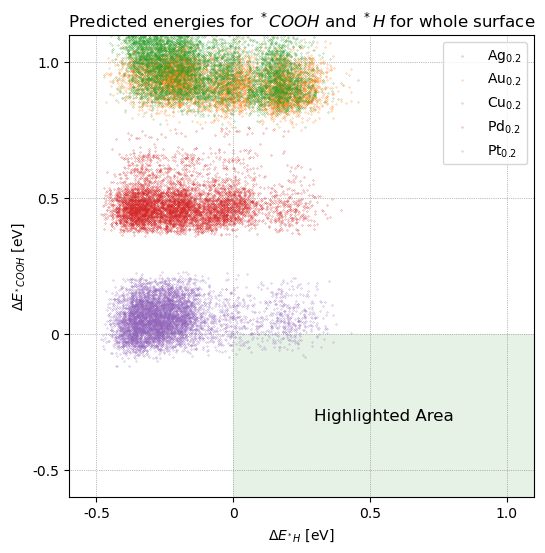

In [186]:
# Create a figure and axes
fig, ax = plt.subplots(figsize = (6, 6))

# Set the limits for both x and y axes
ax.set_xlim(-0.6, 1.1)
ax.set_ylim(-0.6, 1.1)

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xticklabels([-0.5, 0, 0.5, 1.0])
ax.set_yticks([-0.5, 0, 0.5, 1.0])
ax.set_yticklabels([-0.5, 0, 0.5, 1.0])

# Set the grid lines
ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray')

ax.set_title("Predicted energies for $^*COOH$ and $^*H$ for whole surface")
ax.set_xlabel("$\Delta E_{^*H}$ [eV]")
ax.set_ylabel("$\Delta E_{^*COOH}$ [eV]")

#if True: #Lav en firkant, der viser de interante sites
#    ax.hlines(0, 0,  1.1, color='black', linestyle='dotted', linewidth = 0.8, label='Good sites')
#    ax.vlines(0, 0, -0.6, color='black', linestyle='dotted', linewidth = 0.8)

if True:
    # Create a rectangle patch
    rect = patches.Rectangle((0, 0), 1.1, -0.6, linewidth=1, edgecolor='none', facecolor='green', alpha = 0.1)

    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    label_text = 'Highlighted Area' #This can show how many points are in there as well
    label_x = 0.55
    label_y = -0.3
    ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)


for metal in ['Ag', 'Au', 'Cu', 'Pd', 'Pt']:
    ax.scatter(E_hol_dict[metal], E_top_dict[metal], label = f"{metal}$_{{{stochiometry[metal]}}}$", s = 0.04)

ax.legend()

#plt.savefig("")
# Show the plot
plt.show()

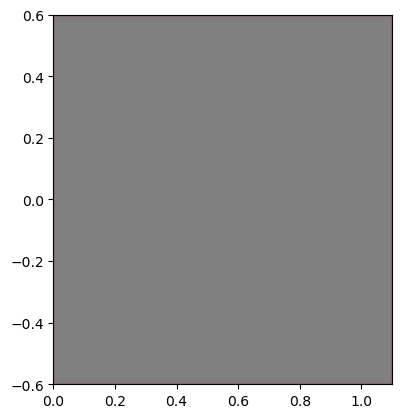

In [176]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the figure and axes
fig, ax = plt.subplots()

# Create a rectangle patch
rect = patches.Rectangle((0, -0.6), 1.1, 1.2, linewidth=1, edgecolor='r', facecolor='gray')

# Add the rectangle to the plot
ax.add_patch(rect)

# Set the aspect ratio to 'equal' for a square plot
ax.set_aspect('equal')

# Set the plot limits
ax.set_xlim(0, 1.1)
ax.set_ylim(-0.6, 0.6)

# Show the plot
plt.show()


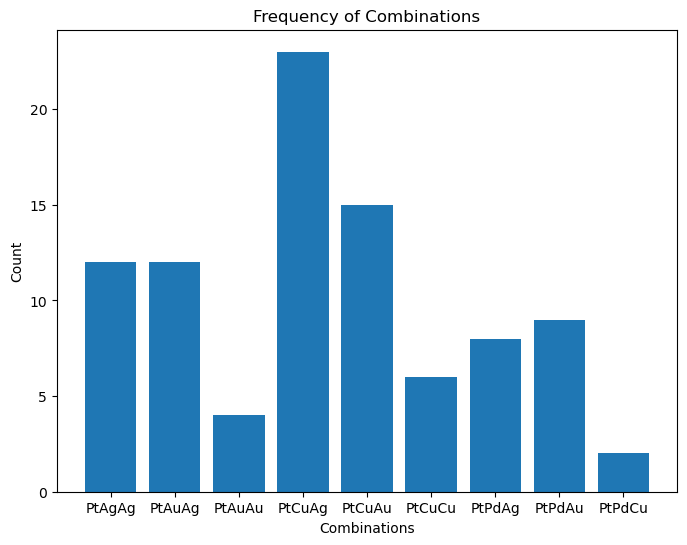

In [145]:
good_hol_sites_sorted = sorted(["".join(sorted(x, reverse = True)) for x in good_hol_sites])
good_hol_sites_dict = Counter(good_hol_sites_sorted)

## Plot
fig, ax = plt.subplots(figsize = (8, 6))

labels = good_hol_sites_dict.keys()
values = good_hol_sites_dict.values()

ax.bar(labels, values)
ax.set_xlabel('Combinations')
ax.set_ylabel('Count')
ax.set_title('Frequency of Combinations')

plt.show()

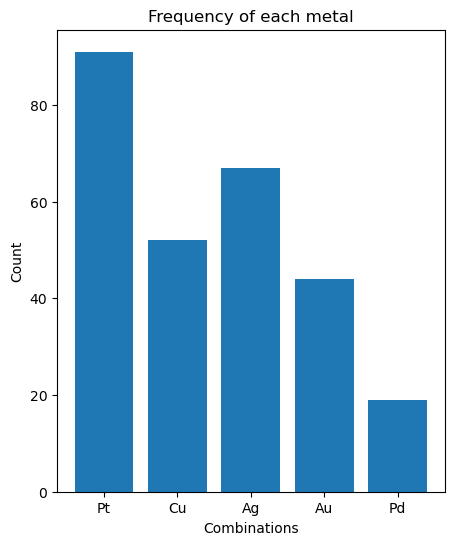

In [161]:
good_hol_sites_flat_dict = Counter(np.array(good_hol_sites).flatten())

## Plot
fig, ax = plt.subplots(figsize = (5, 6))

labels = good_hol_sites_flat_dict.keys()
values = good_hol_sites_flat_dict.values()

ax.bar(labels, values)
ax.set_xlabel('Combinations')
ax.set_ylabel('Count')
ax.set_title('Frequency of each metal')

plt.show()

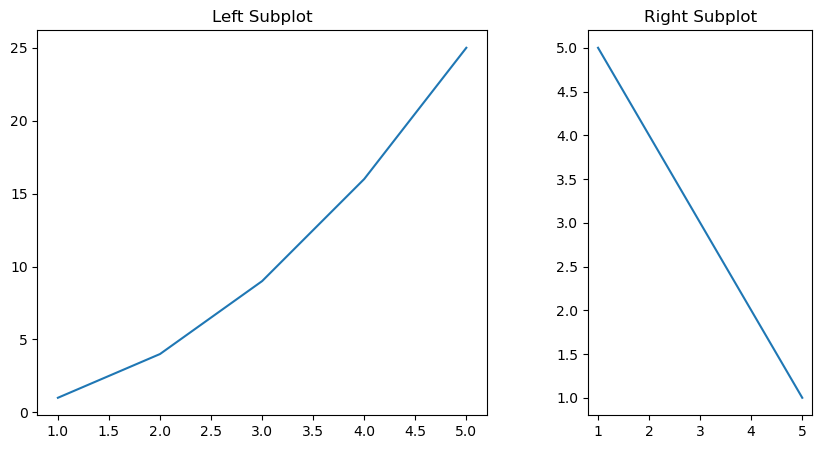

In [150]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create the figure and gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[6, 3])

# Plot on the left subplot
ax1 = plt.subplot(gs[0])
ax1.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])
ax1.set_title('Left Subplot')

# Plot on the right subplot
ax2 = plt.subplot(gs[1])
ax2.plot([1, 2, 3, 4, 5], [5, 4, 3, 2, 1])
ax2.set_title('Right Subplot')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()


In [ ]:
# Cost-function: Hvor mange prikker er under diagonalen
 # Eller negativ deltaE_COOH og positiv deltaE_H

In [54]:
np.shape(surface["atoms"][:, :, 0])

(100, 100)

In [57]:
np.reshape(surface["atoms"][:, :, 0], 100*100)

array(['Au', 'Cu', 'Au', ..., 'Ag', 'Cu', 'Cu'], dtype='<U2')

In [63]:
surface["atoms"][:, :, 0]

array([['Au', 'Cu', 'Au', ..., 'Pd', 'Au', 'Pd'],
       ['Pt', 'Pd', 'Cu', ..., 'Ag', 'Pt', 'Pd'],
       ['Pd', 'Pt', 'Ag', ..., 'Ag', 'Au', 'Pd'],
       ...,
       ['Pt', 'Au', 'Cu', ..., 'Ag', 'Pt', 'Au'],
       ['Pt', 'Pt', 'Au', ..., 'Pd', 'Au', 'Pt'],
       ['Ag', 'Au', 'Pd', ..., 'Ag', 'Cu', 'Cu']], dtype='<U2')

#### Findings

It seems like Pd might be useless, because it's not good enough to make good COOH top-sites and it's not bad anough to make shitty hollow sites. Pd was not useless lmao.

#### Functions

In [30]:
def initialize_surface(dim_x, dim_y, metals, split): #Is still random - could be used with a seed in the name of reproduceability
    dim_z = 3
    
    surf_atoms = create_surface(dim_x, dim_y, metals, split)
    
    # Binding energies
    surf_COOH_E = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# On-top sites
    surf_H_E    = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# Hollow sites
    
    surf = {"atoms": surf_atoms,\
            "COOH_E": surf_COOH_E, "H_E": surf_H_E}
    return surf

def create_surface(dim_x, dim_y, metals, split):
    dim_z = 3
    num_atoms = dim_x*dim_y*dim_z
    if split == "Even":
        proba = [1.0 / len(metals) for n in range(len(metals))] 
        surface = np.random.choice(metals, num_atoms, p=proba)
    else:
        surface = np.random.choice(metals, num_atoms, p=split)
    surface = np.reshape(surface, (dim_x, dim_y, dim_z)) #Reshape list to the
    return surface

def precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G_function):
    for x, y in tqdm([(x, y) for x in range(dim_x) for y in range(dim_y)], desc = r"Predicting all ΔG", leave = True): # I could randomise this, so I go through all sites in a random order
        
        ads = "H"
        surface["H_E"][x][y] = predict_G_function(surface["atoms"], x, y, ads, models) ## A new function that wraps/uses the XGBoost model
        
        ads = "COOH"
        surface["COOH_E"][x][y] = predict_G_function(surface["atoms"], x, y, ads, models) ## A new function that wraps/uses the XGBoost model

    return surface

def predict_G(surface, site_x, site_y, adsorbate, models):
    if adsorbate == "H":
        vector_df = pd.DataFrame([hollow_site_vector(surface, site_x, site_y)], columns = [f"feature{n}" for n in range(55)])
        vector_DM = pandas_to_DMatrix(vector_df)
        G = models["H"].predict(vector_DM)[0]
        return G
    
    if adsorbate == "COOH":
        vector_df = pd.DataFrame([on_top_site_vector(surface, site_x, site_y)], columns = [f"feature{n}" for n in range(20)]) # Tjek - er det ikke "adsorbate" + features?
        vector_DM = pandas_to_DMatrix(vector_df)
        G = models["COOH"].predict(vector_DM)[0]
        return G
    
def on_top_site_vector(surface, site_x, site_y): # I should have done modulo to dim_x and dim_y
    dim_x, dim_y = np.shape(surface)[0], np.shape(surface)[1]
    site1 = [surface[site_x, site_y, 0]]# Make a one-hot encoded vector of the very site here! Add at the beginning 
    site1_count = [site1.count(metals[n]) for n in range(len(metals))]
    
    top6 = [surface[site_x % dim_x, (site_y-1) % dim_y, 0], surface[site_x % dim_x, (site_y+1) % dim_y, 0], surface[(site_x-1) % dim_x, site_y % dim_y, 0], surface[(site_x+1) % dim_x, site_y % dim_y, 0], surface[(site_x-1) % dim_x, (site_y+1) % dim_y, 0], surface[(site_x+1) % dim_x, (site_y-1) % dim_y, 0]]
    top6_count = [top6.count(metals[n]) for n in range(len(metals))]
    
    mid3 = [surface[(site_x-1) % dim_x, (site_y-1) % dim_y,1], surface[site_x % dim_x, (site_y-1) % dim_y,1], surface[(site_x-1) % dim_x, site_y % dim_y,1]]
    mid3_count = [mid3.count(metals[n]) for n in range(len(metals))]
    
    bot3 = [surface[(site_x-1) % dim_x, (site_y-1) % dim_y, 2], surface[(site_x-1) % dim_x, (site_y+1) % dim_y, 2], surface[(site_x+1) % dim_x, (site_y-1) % dim_y, 2]]
    bot3_count = [bot3.count(metals[n]) for n in range(len(metals))]
    
    return site1_count + top6_count + mid3_count + bot3_count

metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
three_metals_combinations = [] #List of possible combinations of the three
# Der skal være 35, ikke 125

for a in metals:
    for b in metals:
        for c in metals:
            three_metals_combinations.append(''.join(sorted([a, b, c])))
            
# Remove duplicates
three_metals_combinations = list(dict.fromkeys(three_metals_combinations)) # Let's encode it in a better way later

def hollow_site_vector(surface, site_x, site_y): #Now with adsorbate encoding
    
    # First encode the 3 neighbours
    blues = [surface[(site_x+1) % dim_x, site_y, 0], surface[site_x, (site_y+1) % dim_y, 0], surface[(site_x+1) % dim_x, (site_y+1) % dim_y, 0]]
    blues = "".join(sorted(blues))
    idx = three_metals_combinations.index(blues)
    blues = 35*[0]
    blues[idx] = 1
    
    # Then the next neighbours (green)
    greens = [surface[(site_x+2) % dim_x, site_y, 0], surface[site_x, (site_y+2) % dim_y, 0], surface[site_x, site_y, 0]]
    greens_count = [greens.count(metals[n]) for n in range(len(metals))]
    
    # Then the next neighbours (brown) # Kunne gøres smartere med list comprehension og to lister med +- zipped
    browns = [surface[(site_x + a) % dim_x, (site_y + b) % dim_y, c] for a, b, c in zip([1, 2, 2, 1, -1, -1], [2, 1, -1, -1, 1, 2], [0, 0, 0, 0, 0, 0])]
    browns_count = [browns.count(metals[n]) for n in range(len(metals))]
    
    # Then the three downstairs neighbours
    yellows = [surface[(site_x + a) % dim_x, (site_y + b) % dim_y, c] for a, b, c in zip([0, 1, 0], [0, 0, 1], [1, 1, 1])]
    yellows_count = [yellows.count(metals[n]) for n in range(len(metals))]
    
    # Then the purples downstairs
    purples = [surface[(site_x + a) % dim_x, (site_y + b) % dim_y, c] for a, b, c in zip([1, -1, 1], [-1, 1, 1], [1, 1, 1])]
    purples_count = [purples.count(metals[n]) for n in range(len(metals))]
    
    return blues + greens_count + browns_count + yellows_count + purples_count

def pandas_to_DMatrix(df):#, label):
    label = pd.DataFrame(np.random.randint(2, size=len(df)))
    DMatrix = xgb.DMatrix(df)#, label=label)
    return DMatrix

#### Training models for COOH and H

In [6]:
def correct_DFT_energy_COOH_DFT(molecules_dict, E_COOH, E_slab):
    return E_COOH - E_slab - molecules_dict["CO2"] - 1/2*molecules_dict["H2"]

def correct_DFT_energy_H_DFT(molecules_dict, E_H, E_slab):
    return E_H - E_slab - 1/2*molecules_dict["H2"]

##### Making features

In [20]:
# Specify metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
alloy = ''.join(metals)

# Specify name of databases
db_name_H = 'H_out.db'
db_name_COOH = 'COOH_C_adsorbed_out.db'
db_name_slab = "slabs_out.db"

# Initiate feature readers
reader_H = FccStandard111(metals)
reader_COOH = OntopStandard111(metals)

site_ids_H = [16, 17, 18]

# Initiate counters of rejected samples
rejected_H = 0
rejected_COOH = 0

# Writer headers to files
with open(f'{features_folder}H_DFT_features.csv', 'w') as file_H:
    column_names = [f"feature{n}" for n in range(55)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_H}row')
    file_H.write(",".join(column_names))
    
# Writer headers to files
with open(f'{features_folder}COOH_DFT_features.csv', 'w') as file_COOH:
    column_names = [f"feature{n}" for n in range(20)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_COOH}row')
    file_COOH.write(",".join(column_names))
    
# Load HEA(111) databases
with connect(f'{db_folder}{db_name_H}') as db_H,\
     connect(f'{db_folder}{db_name_COOH}') as db_COOH,\
     connect(f'{db_folder}{db_name_slab}') as db_slab,\
     open(f'{features_folder}H_DFT_features.csv', 'a') as file_H,\
     open(f'{features_folder}COOH_DFT_features.csv', 'a') as file_COOH:
    #print("A1")
    # Iterate through slabs without adsorbates
    for row_slab in db_slab.select('energy', H=0, C=0, O=0): # This doesn't even trigger lmao
        #print("A2")
        # Iterate through the two adsorbates
        for ads in ['COOH', 'H']:
            #print("A3")
            # Set adsorbate-specific parameters
            if ads == 'COOH':
                db = db_COOH
                kw = {'C': 1,'O': 2, 'H': 1}
                db_name = db_name_COOH
                out_file = file_COOH

            elif ads == 'H':
                db = db_H
                kw = {'O': 0, 'H': 1}
                db_name = db_name_H
                out_file = file_H
                ads_atom = "H"

            # Set counter of matched slabs between the databases to zero
            n_matched = 0

            # Get the corresponding slab with adsorbate
            for row in db.select('energy', **kw, **row_slab.count_atoms()):
                #print("A4")
                # If symbols match up
                if row.symbols[:-len(ads)] == row_slab.symbols:
                    #print("A5")
                    # Increment the counter of matched structures
                    n_matched += 1

                    # Get atoms object
                    atoms = db.get_atoms(row.id)

                    # If the adsorbate is *COOH
                    if ads == 'COOH':
                        # Make slab instance
                        slab = Slab(atoms, ads=ads, ads_atom='C')

                        # Get adsorption site elements as neighbors within a radius
                        site_elems, site = slab.get_adsorption_site(radius=2.6, hollow_radius=2.6)

                        # If the site does not consist of exactly one atom, then skip this sample
                        # as the *OH has moved too far away from an on-top site
                        try:
                            if len(site_elems) !=1:
                                rejected_COOH += 1
                                #slab.view()
                                continue
                        except TypeError:
                            print(site_elems, site)
                            print(row_slab.id, row.id)
                            slab.view()
                            exit()

                        # Get features of structure
                        features = reader_COOH.get_features(slab, radius=2.6)
                        
                        ### This part is now adsorbate-specific ###
                        # Get adsorption energy
                        E_ads = correct_DFT_energy_COOH_DFT(molecules_dict, row.energy, row_slab.energy) # This is the new formula

                        # Write output to file
                        features = ','.join(map(str, features))
                        out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

                    # Else, if the adsorbate is H*
                    elif ads == 'H':
                        
                        atoms = atoms.repeat((3, 3, 1))
                        slab = Slab(atoms, ads=ads, ads_atom=ads_atom)
                        chemical_symbols = atoms.get_chemical_symbols()
                        #view(atoms)
                        H_index = [i for i, x in enumerate(chemical_symbols) if x == "H"][4]
                        
                        all_distances = atoms.get_distances([n for n in list(range(len(chemical_symbols))) if n != H_index], H_index)
                        site_ids_H = np.argpartition(all_distances, 2)[0:3]
                        site_ids_H = [x+1 if x>229 else x for x in site_ids_H] #Compensates for the removal of an H, so that the indices above 229 are not one too small
                        #print("site_ids_H: ", site_ids_H)
                        # Get hollow site planar corner coordinates
                        site_atoms_pos_orig = atoms.positions[site_ids_H, :2]

                        # Get expanded triangle vertices
                        site_atoms_pos = expand_triangle(site_atoms_pos_orig, expansion=1.45)

                        # Get position of adsorbate atom (with atom index XXX 20 XXX)
                        ads_pos = atoms.positions[H_index][:2]

                        # If the H is outside the expanded fcc triangle,
                        # then it is most likely in an hcp site, that is not
                        # being modeled
                        if not inside_triangle(ads_pos, site_atoms_pos):
                            rejected_H += 1
                            continue

                        # Get features of structure
                        features = reader_H.get_features(slab, radius=2.6, site_ids=site_ids_H)

                        ### This part is now adsorbate-specific ###
                        # Get adsorption energy
                        E_ads = correct_DFT_energy_H_DFT(molecules_dict, row.energy, row_slab.energy) # This is the new formula
                        
                        # Write output to file
                        features = ','.join(map(str, features))
                        out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

            if n_matched > 1:
                print(f'[INFO] {n_matched} {ads} and slab matched for row {row_slab.id} in {db_name_slab}')

# Print the number of rejected samples to screen
print('rejected COOH samples: ', rejected_COOH)
print('rejected H samples: ', rejected_H)

[INFO] 9 COOH and slab matched for row 1 in slabs_out.db
[INFO] 9 H and slab matched for row 1 in slabs_out.db
[INFO] 9 COOH and slab matched for row 2 in slabs_out.db
[INFO] 9 H and slab matched for row 2 in slabs_out.db
[INFO] 9 COOH and slab matched for row 3 in slabs_out.db
[INFO] 9 H and slab matched for row 3 in slabs_out.db
[INFO] 9 COOH and slab matched for row 4 in slabs_out.db
[INFO] 8 H and slab matched for row 4 in slabs_out.db
[INFO] 9 COOH and slab matched for row 5 in slabs_out.db
[INFO] 9 H and slab matched for row 5 in slabs_out.db
[INFO] 9 COOH and slab matched for row 6 in slabs_out.db
[INFO] 9 H and slab matched for row 6 in slabs_out.db
[INFO] 9 COOH and slab matched for row 7 in slabs_out.db
[INFO] 9 H and slab matched for row 7 in slabs_out.db
[INFO] 9 COOH and slab matched for row 8 in slabs_out.db
[INFO] 9 H and slab matched for row 8 in slabs_out.db
[INFO] 9 COOH and slab matched for row 9 in slabs_out.db
[INFO] 9 H and slab matched for row 9 in slabs_out.db
[

##### Training models

/Users/marcusnorgaardweng/miniforge3/envs/PUK/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


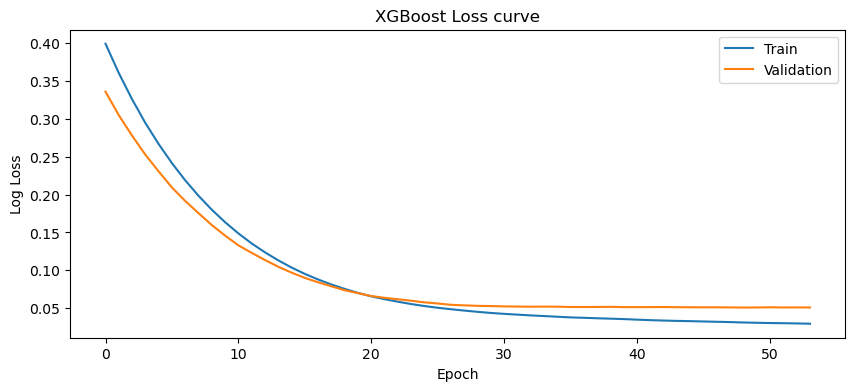

Training score:  0.9911966093244539
Validation score:  0.9764931285341023


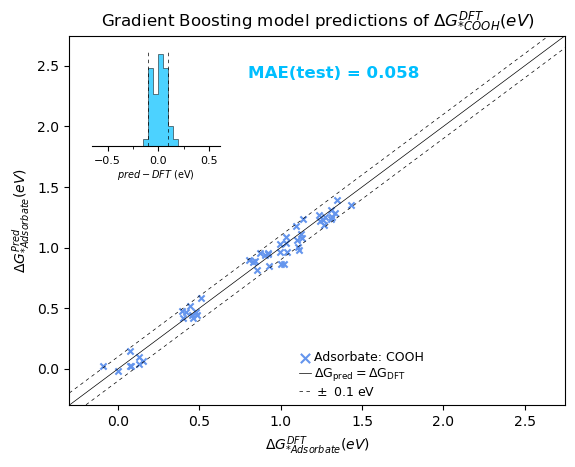

In [11]:
feature_folder = "../csv_features/"
filename = "COOH_DFT_features.csv"

COOH_df = pd.read_csv(feature_folder + filename)
full_df = pd.concat([COOH_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns

X = full_df.loc[:, :all_cols[-4]]
y = full_df[["G_ads (eV)"]]

# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_COOH =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_COOH.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_COOH.save_model("../models/"+"COOH_DFT.model")

learning_curve(XGBModel_COOH)

score = XGBModel_COOH.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_COOH.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)
figure_folder = "../figures/DeltaG_models"
single_parity_plot(XGBModel_COOH, X_test, y_test, "COOH", "COOH") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")

/Users/marcusnorgaardweng/miniforge3/envs/PUK/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


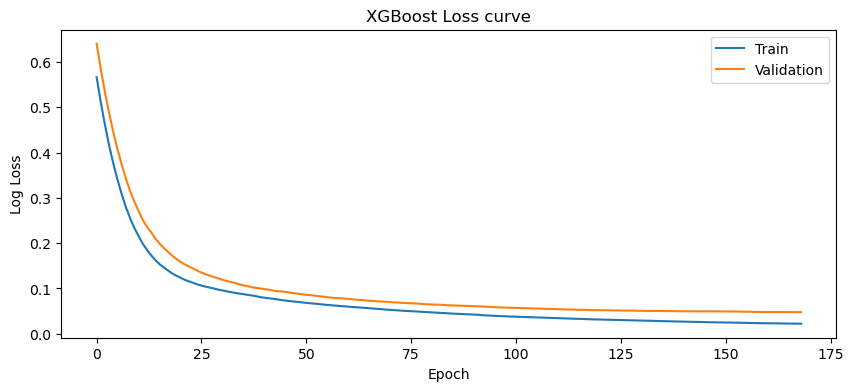

Training score:  0.9831760140145627
Validation score:  0.925897438789119


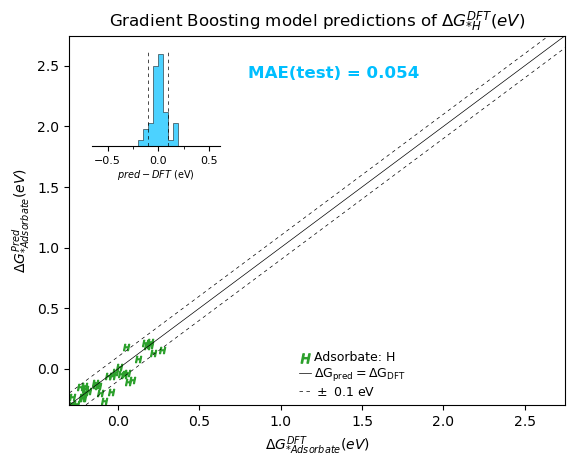

In [21]:
feature_folder = "../csv_features/"
filename = "H_DFT_features.csv"

H_df = pd.read_csv(feature_folder + filename)
full_df = pd.concat([H_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns

X = full_df.loc[:, :all_cols[-4]]
y = full_df[["G_ads (eV)"]]

# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_H =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_H.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_H.save_model("../models/"+"H_DFT.model")

learning_curve(XGBModel_H)

score = XGBModel_H.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_H.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)
figure_folder = "../figures/DeltaG_models"
single_parity_plot(XGBModel_H, X_test, y_test, "H", "H") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")